# Papers without Code EDA and Benchmarking

Very minimal exploratory data analysis on the dataset constructed for testing `papers-without-code`. The purpose is to quantify "what proportion of papers likely use code for their paper but do not link to it in anyway?" Then, analysis on how the package performs.

You can read about the dataset construction on the [data README](./README.md).

In [1]:
# Do some basic data reading and prep
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

df = pd.read_csv("annotated.csv", dtype={"id": str})

# We have only annotated 25 so far
df = df[:25]
df.head()

,id,doi,arxiv_link,update_date,title,best_guess_paper_used_code,code_repository_linked_in_paper,code_repository_link,found_via,comments
0,2101.10263,NaN,https://arxiv.org/abs/2101.10263,2021-01-26,Generative Autoencoder Kernels on Deep Learnin...,yes,no,https://github.com/galtan-PhD/Deep_Autoencoder...,google search corresponding author -> github p...,NaN
1,2106.09719,NaN,https://arxiv.org/abs/2106.09719,2021-12-03,Machining Cycle Time Prediction: Data-driven M...,yes,no,NaN,NaN,NaN
2,2107.05962,NaN,https://arxiv.org/abs/2107.05962,2021-07-23,COLiER: Collaborative Editing of Raster Images,yes,no,NaN,NaN,NaN
3,2112.08371,10.1007/978-3-030-74009-2,https://arxiv.org/abs/2112.08371,2021-12-17,Blockchain as an IoT intermediary,yes,no,NaN,NaN,NaN
4,1803.09565,10.1371/journal.pcbi.1006454,https://arxiv.org/abs/1803.09565,2018-09-13,SIG-DB: leveraging homomorphic encryption to S...,yes,yes,https://github.com/BNext-IQT/GEMstone,NaN,NaN


## "How many papers likely use code?"

Out of the 25 papers annotated so far, 20 "likely used code" as a part of their work in completing the paper. These other papers are commonly math or theory papers where they introduce an algorithm via mathematical notation.

<Axes: xlabel='best_guess_paper_used_code', ylabel='count'>

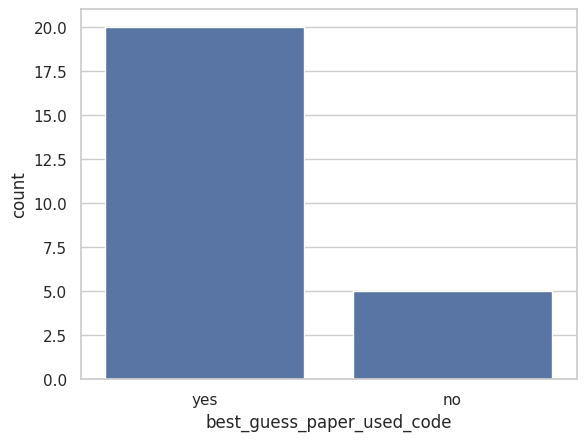

In [2]:
sns.countplot(x=df.best_guess_paper_used_code)

In [3]:
# Filter out the repos where we don't think code was used
# Usually math or theory papers
df = df[df.best_guess_paper_used_code == "yes"]
len(df)

20

## "Of the 20, how many papers can we find repositories for?"

Out of the remaining 20 papers, we can find 13 related repositories. In the cases where we can't find repositories they either were not discoverable within the ~10 minutes I gave to searching for each repository or in one case after searching I assume the code is private because both authors are from private industry.

<Axes: xlabel='code_found', ylabel='count'>

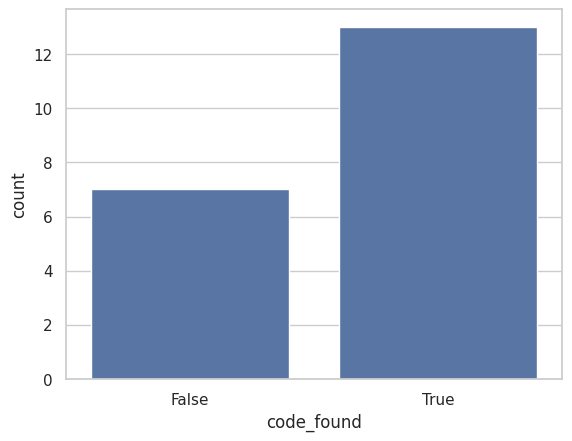

In [4]:
df["code_found"] = ~df.code_repository_link.isna()
sns.countplot(x=df.code_found)

## "How do the papers break down by if code was found AND the code had to be manually found (it _wasn't_ linked in the paper)?"

Of the papers where related code was found, 8 of the papers provided links directly to the code and 5 of the papers I had to manually search for repositories for.

Note on the odd case of "no code was found but a code repository _was_ linked in the paper" is that the code has since been deleted (or was never published) -- however, I found a similar repository authored by one of the authors that I feel would be useful to serve back to users.

<Axes: xlabel='code_found', ylabel='count'>

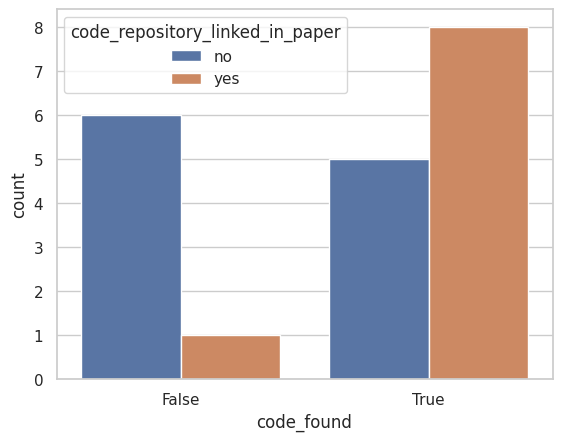

In [5]:
sns.countplot(x="code_found", hue="code_repository_linked_in_paper", data=df)

In [6]:
df[(df.code_found == False) & (df.code_repository_linked_in_paper == "yes")].iloc[0].comments

'code has been removed entirely (or was never published) -- lead author account has contributed to: https://github.com/sisl/AutomotiveDrivingModels.jl which is similar'

## "How many repositories can we find with our automated methods?"

Using the automated search, we only found four repositories that exactly match the ones the paper used for their method or analysis. Of those four, they all came from papers which provided links to their repository in their own paper, but, we didn't even find the fifth paper that did this. We also didn't find any of the repositories which we manually found repositories for.

_The web application uses the same code as the Python package so we can do this analysis in this notebook._

In [7]:
# Get dataframe with just the papers where we manually found code
code_found = df.loc[df.code_found]

In [8]:
from papers_without_code import search_for_repos
from tqdm import tqdm

# Attempt to find repos for each paper and sort their results
matching_results_benchmark_rows = []
for _, row in tqdm(code_found.iterrows(), total=len(code_found)):
    # Prepend the search with arxiv
    paper_repo_results = search_for_repos(f"arxiv:{row.id}")

    # Check all results
    found_match = False
    match_category = ""
    for i, repo in enumerate(paper_repo_results):
        # Check for match
        if repo.link == row.code_repository_link:
            found_match = True
            if i == 0:
                match_category = "first"
            elif i < 3:
                match_category = "top three"
            elif i < 5:
                match_category = "top five"
            else:
                match_category = "after top five"

            # Break out and finish up this paper
            break

    # Update row with info
    if found_match:
        row["match"] = match_category
    else:
        row["match"] = "not found"

    # Add row to new dataframe
    matching_results_benchmark_rows.append(row)
    
matching_results_benchmark = pd.DataFrame(matching_results_benchmark_rows)

/home/eva/miniforge-pypy3/envs/pwoc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                                                                                                                                  | 0/13 [00:00<?, ?it/s]/home/eva/miniforge-pypy3/envs/pwoc/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda

In [9]:
matching_results_benchmark[["id", "code_repository_linked_in_paper", "match"]]

,id,code_repository_linked_in_paper,match
0,2101.10263,no,not found
4,1803.09565,yes,first
5,2202.13538,yes,first
6,2111.14338,yes,first
9,1706.07119,yes,not found
10,2003.01479,yes,first
11,2110.06912,no,not found
13,2205.04892,no,not found
14,1501.05151,no,not found
16,2007.10100,no,top three


## Takeaways

### The Bad

Our search isn't that great at finding the _exact_ matching repository to the paper. I think a large portion of the failure comes because of two things:

1. GitHub's API has an incredibly strict rate limit. In order to make the search work efficiently, I am using repository searches and not "code searches". By looking at the tqdm average from the prior processing cell, we can see that on average searches were completed in ~20 seconds. This is the tradeoff I had to make.

2. If you look at my original annotation data, I left notes as to how I found multiple of the repositories. In many cases I was searching for one of the paper authors GitHub profile and then looking at only their repositories. In this current search, we are just doing keyword searches across all repositories.

### The Good

It isn't all for waste in my opinion though. While the original intent was to find GitHub repositories which are the exact match for a paper, we are able to find repositories that are similar or may still be useful to the user. I don't have any qualitative data to back this up but from my own experiences, I have found repositories related to my own research that I have never seen before but are incredibly relevent.